# Simple Distribution Fitting

In these examples we just use our laplace approximation to fit a known posterior distribution in one and two dimensions, and see how well it reproduces the posterior.

## One Dimension Beta Distribution

In [1]:
import jax.numpy as jnp
from jax import random
from melvin import LaplaceApproximation
import jax
import matplotlib.pylab as plt
from functools import partial

jax.config.update("jax_enable_x64", True)

In [2]:
SEED = random.PRNGKey(220)

MU = 0.3
APB = 10

ALPHA = MU * APB
BETA = (1.0 - MU) * APB

In [3]:
class BetaPosteriorOptimizer(LaplaceApproximation):
    param_bounds = jnp.array([[0.0, 1.0]])
    
    def log_prior(self, params):
        return jax.scipy.stats.beta.logpdf(x=params[0], a=ALPHA, b=BETA)

    def log_likelihood(self, params, y, y_pred):
        return 0.0

initial_params = jnp.array([0.5])

model = BetaPosteriorOptimizer(
    name="Beta Posterior Optimizer",
    initial_params=initial_params
)
print(model)

Laplace Approximation: Beta Posterior Optimizer
Base distribution: normal
Fixed Parameters: []
Fit converged successfully
Fitted Parameters: 
[
  0.2500002248973315 +/- 0.15309315483089667,	 [Lower Bound = 0.0]	 [Upper Bound = 1.0]
]
MAP Posterior Prob = 1.030747930559878


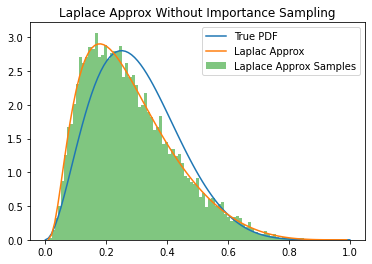

In [4]:
x = jnp.linspace(0.0, 1.0, 100)
y = jax.scipy.stats.beta.pdf(x=x, a=ALPHA, b=BETA)

laplace_logpdf_vec = jax.vmap(model.laplace_log_posterior)
y_approx = jnp.exp(laplace_logpdf_vec(x.reshape(-1,1)).reshape(-1))

SEED, _seed = random.split(SEED)

samples = model.sample_params(prng_key=_seed, n_samples=10000, method="simple")

plt.plot(x,y,label="True PDF")
plt.plot(x,y_approx, label="Laplac Approx")
plt.hist(samples.reshape(-1), bins=x, density=True, label="Laplace Approx Samples", alpha=0.6)
plt.title("Laplace Approx Without Importance Sampling")
plt.legend()
plt.show()

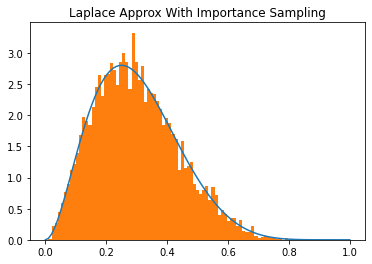

In [5]:
importance_samples = model.sample_params(prng_key=_seed, n_samples=10000, method="importance")

plt.plot(x,y, label="True PDF")
plt.hist(importance_samples.reshape(-1), bins=x, density=True, label="Importance-Laplace Approx Samples")
plt.title("Laplace Approx With Importance Sampling")
plt.show()

In [6]:
print(model.evaluate_samples(samples))
print(model.evaluate_samples(importance_samples))

-0.028725638395464936
0.010597685119911326


## Two Dimensional: Normal / Gamma

In [7]:
X_MU = 2.0
X_STD = 1.0
Y_MU = 5.0
Y_SCALE = 1.0

In [8]:
class NormalGammaOptimizer(LaplaceApproximation):
    param_bounds = jnp.array([[jnp.nan, jnp.nan], [0, jnp.nan]])

    def log_prior(self, params):
        x_log_pdf = jax.scipy.stats.norm.logpdf(x=params[0], loc=X_MU, scale=X_STD)
        y_log_pdf = jax.scipy.stats.gamma.logpdf(x=params[1], a=Y_MU, scale=Y_SCALE)
        return x_log_pdf + y_log_pdf

    def log_likelihood(self, params, y, y_pred):
        return 0.0

initial_params = jnp.array([0.5, 0.2])

model = NormalGammaOptimizer(
    name="Normal Gamma Optimizer",
    initial_params=initial_params,
)
print(model)

Laplace Approximation: Normal Gamma Optimizer
Base distribution: normal
Fixed Parameters: []
Fit converged successfully
Fitted Parameters: 
[
  2.0000026375787967 +/- 1.0,
  4.000001361417955 +/- 2.0000003403544597,	 [Lower Bound = 0.0]
]
MAP Posterior Prob = -2.5518149190767656


In [9]:
x = jnp.linspace(-0.5,4.5,100)
y = jnp.linspace(0.0,10.0,100)

xy = jnp.array([
    [x_i, y_i] for y_i in y for x_i in x 
])

model_vec = jax.vmap(model._log_posterior, (0, None, None))
log_pdf_true = model_vec(xy, None, None).reshape(100,100)

In [10]:
samples = model.sample_params(prng_key=_seed, n_samples=100000, method="simple").reshape(-1, 2)

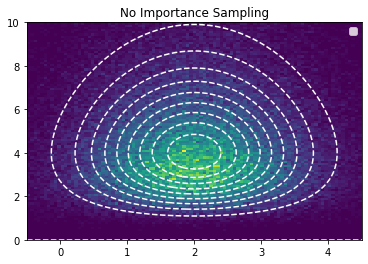

In [11]:
plt.contour(x, y, jnp.exp(log_pdf_true), linestyles="dashed", levels=10, lw=1, colors="white")
plt.hist2d(samples[:,0], samples[:,1], bins=(x,y))
plt.legend()
plt.title("No Importance Sampling")
plt.show()

In [12]:
importance_samples = model.sample_params(prng_key=_seed, n_samples=100000, method="importance").reshape(-1, 2)

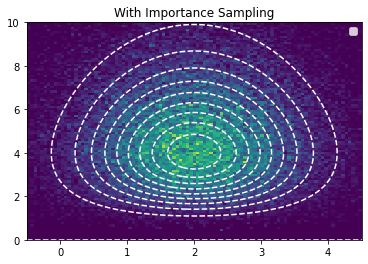

In [13]:
plt.contour(x, y, jnp.exp(log_pdf_true), linestyles="dashed", levels=10, lw=1, colors="white")
plt.hist2d(importance_samples[:,0], importance_samples[:,1], bins=(x,y))
plt.legend()
plt.title("With Importance Sampling")
plt.show()

In [14]:
print(model.evaluate_samples(samples[:10000, :]))
print(model.evaluate_samples(importance_samples[:10000, :]))

-0.02558080042161759
0.014126322603956964
